# 自编码网络的简单介绍

首先通过隐藏层将信息进行特征编码（高纬信息削减为几个编码信息），然后通过隐藏层解码，输出和输入数据尺寸一样的信息。

In [1]:
# 导入需要的模块

import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import nn
import torch.functional as F
import torch.optim as optim

import torch.utils.data as Data

In [2]:
# 加载数据集
from torchvision.datasets import MNIST
from torchvision import transforms
train_data = MNIST(
    root = "./data/MNIST",
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

test_data = MNIST(
    root = "./data/MNIST",
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

# 将图像转化为向量数据
train_data_x = train_data.data.type(torch.FloatTensor)/255.0
train_data_x = train_data_x.reshape(train_data_x.shape[0], -1)
train_data_y = train_data.targets

test_data_x = test_data.data.type(torch.FloatTensor)/255.0
test_data_x = test_data_x.reshape(test_data_x.shape[0], -1)
test_data_y = test_data.targets

#定义加载器
train_loader = Data.DataLoader(
    dataset = train_data_x,
    batch_size = 64,
    shuffle = True,
    num_workers = 4,
)

print("训练数据集：", train_data_x.shape)
print("测试数据集：", test_data_x.shape)

训练数据集： torch.Size([60000, 784])
测试数据集： torch.Size([10000, 784])


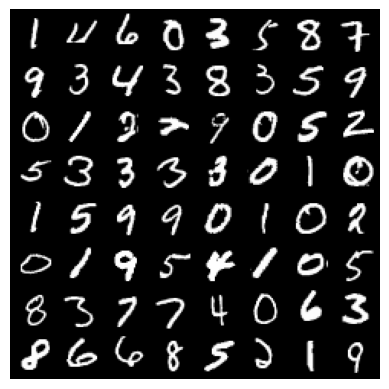

In [3]:
#可视化一个 batch 的内容
from torchvision.utils import make_grid #该函数直接将数据结构[batch, channel, height, weigh] 形式转化为图像矩阵

for step , b_x in enumerate(train_loader):
    if step > 4: break

im = make_grid(b_x.reshape((-1, 1, 28, 28)))
im = im.data.numpy().transpose((1, 2, 0))

plt.figure()
plt.imshow(im)
plt.axis("off")
plt.show()

In [4]:
#自编码网络构建
class EnDecoder(nn.Module):
    def __init__(self):
        super(EnDecoder, self).__init__()
        # 编码过程
        self.Encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 3),
            nn.Tanh(),
        )

        #解码过程
        self.Decoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 512),
            nn.Tanh(),
            nn.Linear(512, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)

        return encoder, decoder

# 输出网络结构
edmodel = EnDecoder()
print(edmodel)

EnDecoder(
  (Encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=3, bias=True)
    (7): Tanh()
  )
  (Decoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


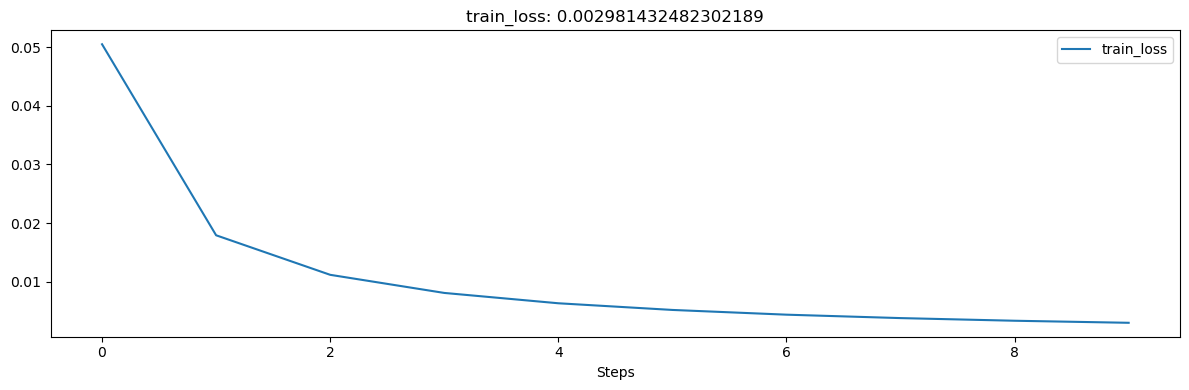

In [5]:
# 网络训练

# 定义优化器
optimizer = optim.Adam(edmodel.parameters(), lr=0.001)
loss_func = nn.MSELoss()

# 记录训练过程指标
import hiddenlayer as hl
history1 = hl.History()

# 使用 Canvas 进行可视化
canvasl = hl.Canvas()
train_num = 0
val_num = 0

# 对模型进行迭代训练，对所有的数据训练 epoch 轮
for epoch in range(10):
    train_loss_epoch = 0
    # 对训练数据的加载器进行迭代计算
    for step, b_x in enumerate(train_loader):
        _, output = edmodel(b_x)
        loss = loss_func(output, b_x)   # 计算均方损失
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        loss.backward()                 # 计算梯度
        optimizer.step()                # 使用梯度进行优化
        train_loss_epoch += loss.item() * b_x.size(0)
        train_num = train_num + b_x.size(0)

    # 计算一个 epoch 的损失
    train_loss = train_loss_epoch / train_num
    # 保存每个 epoch 上的输出 loss
    history1.log(epoch, train_loss=train_loss)
    # 可视网络训来过程
    with canvasl:
        canvasl.draw_plot(history1["train_loss"])

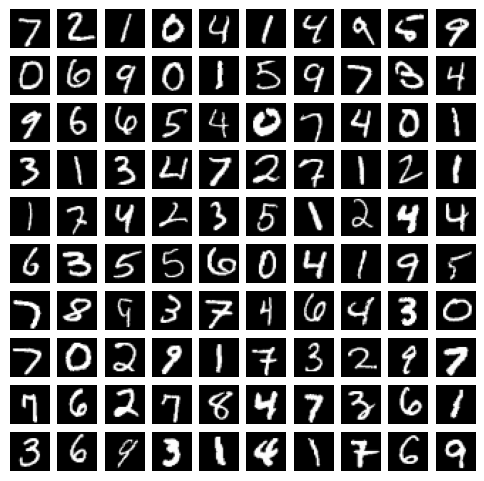

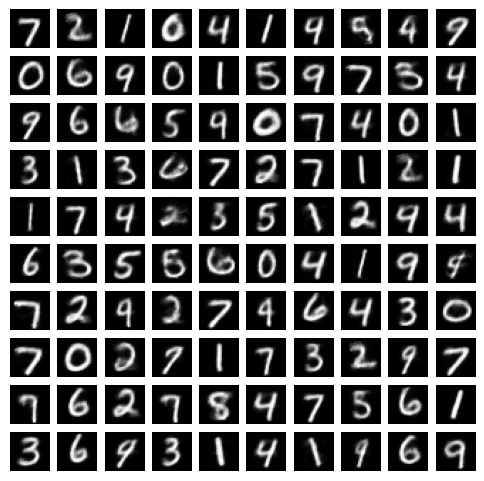

In [6]:
# 预测测试集前100张图像的输出
edmodel.eval()
_, test_decoder = edmodel(test_data_x[:100, :])

# 可视化原图像
plt.figure(figsize=(6, 6))
for i in range(test_decoder.shape[0]):
    plt.subplot(10, 10, i+1)
    im = test_data_x[i, :]
    im = im.data.numpy().reshape(28, 28)
    plt.imshow(im, cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

# 可视化编码后图像
plt.figure(figsize=(6, 6))
for i in range(test_decoder.shape[0]):
    plt.subplot(10, 10, i+1)
    im = test_decoder[i, :]
    im = im.data.numpy().reshape(28, 28)
    plt.imshow(im, cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

In [7]:
# 网络编码特征可视化
# 获取前500个样本的自编码后的特征
edmodel.eval()
TEST_num = 500
test_encoder, _ = edmodel(test_data_x[0:TEST_num, :])
print("test_encoder.shape:", test_encoder.shape)

test_encoder.shape: torch.Size([500, 3])


# 自编码网络特征提取
当时用其它的网络对数据进行分类的时候，自编码网络的作用是对数据新型特征提取和数据降维。

接下来将会使用自编码网络结合 SVM，并与 PCA 方法结合 SVM 进行对比。

In [8]:
edmodel = EnDecoder()
edmodel.eval()

# 自编后产生的测试集和训练集
train_ed_x, _ = edmodel(train_data_x)
train_ed_x = train_ed_x.data.numpy()
train_y = train_data_y.data.numpy()

test_ed_x, _ = edmodel(test_data_x)
test_ed_x = test_ed_x.data.numpy()
test_y = test_data_y.data.numpy()

In [9]:
# PCA 降维获得训练集和测试集前3个主成分
from sklearn.decomposition import PCA
pcamodel = PCA(n_components=3, random_state=10)
train_pca_x = pcamodel.fit_transform(train_data_x.data.numpy())
test_pca_x = pcamodel.transform(test_data_x.data.numpy())
print(train_pca_x.shape)

(60000, 3)


In [10]:
# 使用自编码模型建立分类器，训练和预测
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

encodersvc = SVC(kernel='rbf', random_state=123)
encodersvc.fit(train_ed_x, train_y)
edsvc_pre = encodersvc.predict(test_ed_x)

print(classification_report(test_y, edsvc_pre))
print("模型精度：", accuracy_score(test_y, edsvc_pre))

              precision    recall  f1-score   support

           0       0.46      0.47      0.46       980
           1       0.35      0.78      0.48      1135
           2       0.31      0.26      0.28      1032
           3       0.33      0.47      0.39      1010
           4       0.33      0.20      0.25       982
           5       0.24      0.05      0.09       892
           6       0.53      0.50      0.51       958
           7       0.45      0.51      0.48      1028
           8       0.13      0.04      0.06       974
           9       0.33      0.33      0.33      1009

    accuracy                           0.37     10000
   macro avg       0.35      0.36      0.33     10000
weighted avg       0.35      0.37      0.34     10000

模型精度： 0.3716


In [11]:
# 使用 PCA 降维数据建立分类器，训练和预测
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

pcasvc = SVC(kernel='rbf', random_state=123)
pcasvc.fit(train_pca_x, train_y)
pcasvc_pre = pcasvc.predict(test_pca_x)

print(classification_report(test_y, pcasvc_pre))
print("模型精度：", accuracy_score(test_y, pcasvc_pre))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71       980
           1       0.93      0.95      0.94      1135
           2       0.51      0.49      0.50      1032
           3       0.65      0.64      0.64      1010
           4       0.41      0.55      0.47       982
           5       0.42      0.31      0.36       892
           6       0.38      0.60      0.47       958
           7       0.52      0.51      0.52      1028
           8       0.41      0.26      0.32       974
           9       0.44      0.30      0.36      1009

    accuracy                           0.54     10000
   macro avg       0.54      0.53      0.53     10000
weighted avg       0.54      0.54      0.54     10000

模型精度： 0.5425
